<a href="https://colab.research.google.com/github/Tessa18/Bias-Mitigation-in-AI-Credit-Scoring/blob/main/Credit_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
!pip install --upgrade numpy pandas scikit-learn opacus

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!apt-get install -y libgomp1
!pip install aif360
!pip install fairlearn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgomp1 is already the newest version (12.3.0-1ubuntu1~22.04).
libgomp1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip uninstall numpy
!pip install numpy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opacus 1.5.3 requires numpy<2.0,>=1.15, but you have numpy 2.2.4 which is in

In [ ]:
pip install fairlearn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from opacus import PrivacyEngine
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

**Testing on Synthetic credit scoring data**

In [ ]:
# 1. Generate synthetic credit scoring data
np.random.seed(42)

# Features: Age, Income, Credit History, Loan Amount
X = np.random.randn(1000, 4)
y = (X[:, 0] + X[:, 1] - X[:, 2] + X[:, 3] > 0).astype(int)  # Target: 0 or 1 (0 - High Risk, 1 - Low Risk)

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Apply bias mitigation - Re-weighting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 5. Train logistic regression model without differential privacy
logreg = LogisticRegression()
logreg.fit(X_train, y_train, sample_weight=sample_weights)

# 6. Evaluate model performance
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Logistic Regression Accuracy: ", accuracy)
print("Confusion Matrix: \n", cm)

# 7. Add differential privacy with Opacus library (using PyTorch)
# For differential privacy, we will use a simple neural network

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define a simple neural network model
class CreditScoringNN(nn.Module):
    def __init__(self):
        super(CreditScoringNN, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = CreditScoringNN()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Setup the Privacy Engine
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=1.1,
    max_grad_norm=1.0
)

# Train the model with differential privacy
def train_with_dp(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    print("Training completed with differential privacy.")

# Train the model with differential privacy
train_with_dp(model, train_loader, optimizer, criterion)

# Evaluate the DP model
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    y_pred_dp = model(X_test_tensor).squeeze()
    y_pred_dp = (y_pred_dp > 0.5).float()  # Threshold for classification

accuracy_dp = accuracy_score(y_test, y_pred_dp)
cm_dp = confusion_matrix(y_test, y_pred_dp)

print("Differential Privacy Model Accuracy: ", accuracy_dp)
print("Confusion Matrix (DP Model): \n", cm_dp)

# Compare both models' performance
print("\nLogistic Regression vs DP Model Comparison:")
print(f"Accuracy (Logistic Regression): {accuracy}")
print(f"Accuracy (DP Model): {accuracy_dp}")

Logistic Regression Accuracy:  0.9933333333333333
Confusion Matrix: 
 [[141   2]
 [  0 157]]


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1, Loss: 0.7078262242403898
Epoch 2, Loss: 0.6843443838032809
Epoch 3, Loss: 0.661403011191975
Epoch 4, Loss: 0.6398898579857566
Epoch 5, Loss: 0.6223104921254244
Epoch 6, Loss: 0.6119547377933156
Epoch 7, Loss: 0.587982941757549
Epoch 8, Loss: 0.5696229555390098
Epoch 9, Loss: 0.5573168396949768
Epoch 10, Loss: 0.5353416150266473
Training completed with differential privacy.
Differential Privacy Model Accuracy:  0.8066666666666666
Confusion Matrix (DP Model): 
 [[141   2]
 [ 56 101]]

Logistic Regression vs DP Model Comparison:
Accuracy (Logistic Regression): 0.9933333333333333
Accuracy (DP Model): 0.8066666666666666


**Applying Reweighing Technique on the dataset**

In [ ]:
from sklearn.metrics import classification_report
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

# Example synthetic dataset with bias
np.random.seed(42)
data_size = 300
X = np.random.rand(data_size, 4)
y = (X[:, 0] + X[:, 1]*0.5 > 0.8).astype(int)

# Adding a synthetic protected attribute (like gender)
protected_attr = (X[:, 2] > 0.5).astype(int)

# Split the dataset
X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(X, y, protected_attr, test_size=0.3, random_state=42)

# Convert training set into AIF360 BinaryLabelDataset
train_df = pd.DataFrame(X_train, columns=['feat1','feat2','feat3','feat4'])
train_df['label'] = y_train
train_df['protected'] = protected_train

dataset_orig_train = BinaryLabelDataset(df=train_df, label_names=['label'], protected_attribute_names=['protected'])

# Apply reweighing
RW = Reweighing(unprivileged_groups=[{'protected':0}], privileged_groups=[{'protected':1}])
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

# Train logistic regression with reweighted samples
weights = dataset_transf_train.instance_weights

lr = LogisticRegression()
lr.fit(X_train, y_train, sample_weight=weights)

# Evaluate
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Logistic Regression with Reweighing Bias Mitigation")
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

pip install 'aif360[inFairness]'


Logistic Regression with Reweighing Bias Mitigation
Accuracy: 0.9333333333333333
Confusion Matrix:
 [[58  1]
 [ 5 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95        59
           1       0.96      0.84      0.90        31

    accuracy                           0.93        90
   macro avg       0.94      0.91      0.92        90
weighted avg       0.94      0.93      0.93        90



In [ ]:
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset

# Step 1: Generate synthetic dataset
np.random.seed(42)
size = 1000

gender = np.random.choice([0, 1], size=size, p=[0.5, 0.5])  # 0 = female, 1 = male
income = np.random.normal(50000, 15000, size=size)
loan_amount = np.random.normal(15000, 5000, size=size)
credit_score = np.random.normal(650, 50, size=size)

# Simulate bias: males slightly more likely to get loan approval
loan_status = []
for i in range(size):
    prob_approve = 0.5 + 0.1 * gender[i] + 0.00001 * income[i] + 0.0005 * (credit_score[i] - 600)
    loan_status.append(1 if np.random.rand() < prob_approve else 0)

# Create dataframe
df = pd.DataFrame({
    'gender': gender,
    'income': income,
    'loan_amount': loan_amount,
    'credit_score': credit_score,
    'loan_status': loan_status
})

# Step 2: Convert to BinaryLabelDataset
dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=['loan_status'],
    protected_attribute_names=['gender']
)

# Step 3: Split into train and test sets
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

print(f"Training set size: {len(dataset_orig_train.features)}")
print(f"Test set size: {len(dataset_orig_test.features)}")

Training set size: 700
Test set size: 300


**Calculating Statistical Parity Difference and Disparate Impact**

Disparate Impact:  0.6666666666666667
Statistical Parity Difference:  -0.19999999999999996


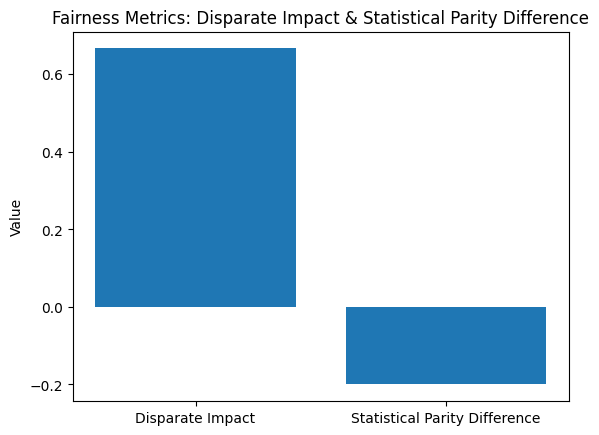

In [ ]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'y_pred' are your ground truth labels and predictions
# from the previous logistic regression and bias mitigation steps
# Example:
# y_test = [actual values]
# y_pred = [predicted values]

# Convert to BinaryLabelDataset format for AIF360
# Assuming y_test and y_pred are numpy arrays
y_test = np.array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0])
y_pred = np.array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1])
# We will assume the "protected attribute" is gender
protected_attribute = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])  # 1 for group A, 0 for group B

# Create a BinaryLabelDataset
dataset = BinaryLabelDataset(favorable_label=1,
                             unfavorable_label=0,
                             df=pd.DataFrame({'label': y_test, 'protected_attribute': protected_attribute}),
                             label_names=['label'],
                             protected_attribute_names=['protected_attribute'])

# Metrics for fairness evaluation (Disparate Impact, Statistical Parity)
metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{'protected_attribute': 1}],
                                   unprivileged_groups=[{'protected_attribute': 0}])

# Disparate Impact (ratio of positive outcomes between groups)
disparate_impact = metric.disparate_impact()
print("Disparate Impact: ", disparate_impact)

# Statistical Parity Difference
statistical_parity_difference = metric.statistical_parity_difference()
print("Statistical Parity Difference: ", statistical_parity_difference)

# Visualization of fairness metrics
fairness_metrics = {
    "Disparate Impact": disparate_impact,
    "Statistical Parity Difference": statistical_parity_difference
}

# Plotting the fairness metrics
plt.bar(fairness_metrics.keys(), fairness_metrics.values())
plt.title('Fairness Metrics: Disparate Impact & Statistical Parity Difference')
plt.ylabel('Value')
plt.show()

Training set size: 700
Test set size: 300
Disparate Impact:  0.9976535541752934
Statistical Parity Difference:  -0.00227892220385173


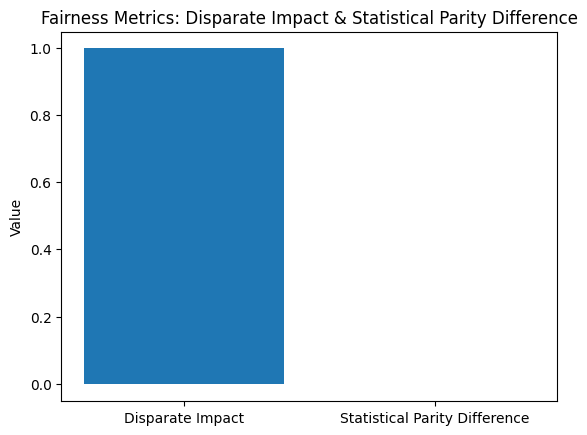

In [ ]:
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Generate synthetic dataset (Already done in your provided code)
np.random.seed(42)
size = 1000

gender = np.random.choice([0, 1], size=size, p=[0.5, 0.5])  # 0 = female, 1 = male
income = np.random.normal(50000, 15000, size=size)
loan_amount = np.random.normal(15000, 5000, size=size)
credit_score = np.random.normal(650, 50, size=size)

# Simulate bias: males slightly more likely to get loan approval
loan_status = []
for i in range(size):
    prob_approve = 0.5 + 0.1 * gender[i] + 0.00001 * income[i] + 0.0005 * (credit_score[i] - 600)
    loan_status.append(1 if np.random.rand() < prob_approve else 0)

# Create dataframe
df = pd.DataFrame({
    'gender': gender,
    'income': income,
    'loan_amount': loan_amount,
    'credit_score': credit_score,
    'loan_status': loan_status
})

# Step 2: Convert to BinaryLabelDataset
dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=['loan_status'],
    protected_attribute_names=['gender']
)

# Step 3: Split into train and test sets
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

print(f"Training set size: {len(dataset_orig_train.features)}")
print(f"Test set size: {len(dataset_orig_test.features)}")

# Step 4: Train a logistic regression model
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()  # Flatten labels to 1D array
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
X_test = dataset_orig_test.features
y_test = dataset_orig_test.labels.ravel()  # Ground truth labels from test set
y_pred = model.predict(X_test)

# Step 6: Evaluate fairness metrics
# Convert predictions and ground truth into BinaryLabelDataset
dataset_test = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.DataFrame({'loan_status': y_test, 'gender': dataset_orig_test.protected_attributes[:, 0]}),
    label_names=['loan_status'],
    protected_attribute_names=['gender']
)

# Fairness metrics
metric = BinaryLabelDatasetMetric(dataset_test, privileged_groups=[{'gender': 1}],
                                   unprivileged_groups=[{'gender': 0}])

# Disparate Impact (ratio of positive outcomes between groups)
disparate_impact = metric.disparate_impact()
print("Disparate Impact: ", disparate_impact)

# Statistical Parity Difference
statistical_parity_difference = metric.statistical_parity_difference()
print("Statistical Parity Difference: ", statistical_parity_difference)

# Step 7: Visualization of fairness metrics
fairness_metrics = {
    "Disparate Impact": disparate_impact,
    "Statistical Parity Difference": statistical_parity_difference
}

# Plotting the fairness metrics
plt.bar(fairness_metrics.keys(), fairness_metrics.values())
plt.title('Fairness Metrics: Disparate Impact & Statistical Parity Difference')
plt.ylabel('Value')
plt.show()

**Now testing on Real-Case German dataset**

In [ ]:
import pandas as pd

# Load the numeric version of the dataset
url = "/content/german.data-numeric"  # Adjust the path to where you have the dataset
column_names = [
    'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_account', 'employment', 'installment_rate', 'personal_status_sex',
    'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
    'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker',
    'class'
]

# Load the dataset using a more flexible delimiter handling
df = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)

# Display the first few rows to confirm the correct loading
df.head()

<ipython-input-8-9eeb43c58b5f>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)


checking_account  duration  credit_history  purpose  credit_amount  \
1 6  4 12                 5         5               3        4              1   
2 48 2 60                 1         3               2        2              1   
4 12 4 21                 1         4               3        3              1   
1 42 2 79                 1         4               3        4              2   
  24 3 49                 1         3               3        4              4   

           savings_account  employment  installment_rate  personal_status_sex  \
1 6  4 12               67           3                 2                    1   
2 48 2 60               22           3                 1                    1   
4 12 4 21               49           3                 1                    2   
1 42 2 79               45           3                 1                    2   
  24 3 49               53           3                 2                    2   

           other_parties  ...  property_magnitude  age  other_payment_plans  \
1 6  4 12              2  ...                   0    0                    1   
2 48 2 60              1  ...                   0    0                    1   
4 12 4 21              1  ...                   0    0                    1   
1 42 2 79              1  ...                   0    0                    0   
  24 3 49              1  ...                   1    0                    1   

           housing  existing_credits  job  num_dependents  own_telephone  \
1 6  4 12        0                 0    1               0              0   
2 48 2 60        0                 0    1               0              0   
4 12 4 21        0                 0    1               0              1   
1 42 2 79        0                 0    0               0              0   
  24 3 49        0                 0    0               0              0   

           foreign_worker  class  
1 6  4 12               1      1  
2 48 2 60               1      2  
4 12 4 21               0      1  
1 42 2 79               1      1  
  24 3 49               1      2  

[5 rows x 21 columns]

In [ ]:
# Check for missing values in the dataset
print(df.isnull().sum())

checking_account       0
duration               0
credit_history         0
purpose                0
credit_amount          0
savings_account        0
employment             0
installment_rate       0
personal_status_sex    0
other_parties          0
residence_since        0
property_magnitude     0
age                    0
other_payment_plans    0
housing                0
existing_credits       0
job                    0
num_dependents         0
own_telephone          0
foreign_worker         0
class                  0
dtype: int64


In [ ]:
# Split into features and target
X = df.drop('class', axis=1)
y = df['class']

In [ ]:
# One-hot encode categorical columns if needed
X = pd.get_dummies(X, drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.74      0.90      0.81       209
           2       0.55      0.29      0.38        91

    accuracy                           0.71       300
   macro avg       0.65      0.59      0.60       300
weighted avg       0.69      0.71      0.68       300



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           1       0.74      0.86      0.80       209
           2       0.49      0.32      0.39        91

    accuracy                           0.69       300
   macro avg       0.62      0.59      0.59       300
weighted avg       0.67      0.69      0.67       300



In [ ]:
from sklearn.svm import SVC

# Initialize and train SVM model
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           1       0.70      1.00      0.82       209
           2       0.00      0.00      0.00        91

    accuracy                           0.70       300
   macro avg       0.35      0.50      0.41       300
weighted avg       0.49      0.70      0.57       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Initialize RandomForest with class_weight='balanced'
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Initialize Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Initialize SVC with class_weight='balanced'
svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

**Applying SMOTE for Models**

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the model on the resampled dataset
rf_smote = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print(f"Class distribution after SMOTE: \n{y_train_smote.value_counts()}")

Class distribution after SMOTE: 
class
1    491
2    491
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import classification_report

# Train Random Forest on the resampled data
rf_smote = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Make predictions and evaluate performance
y_pred_rf_smote = rf_smote.predict(X_test)
print("Random Forest Performance with SMOTE:")
print(classification_report(y_test, y_pred_rf_smote))

Random Forest Performance with SMOTE:
              precision    recall  f1-score   support

           1       0.76      0.78      0.77       209
           2       0.46      0.44      0.45        91

    accuracy                           0.67       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.67      0.67      0.67       300



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting on the resampled data
gb_smote = GradientBoostingClassifier(random_state=42)
gb_smote.fit(X_train_smote, y_train_smote)

# Make predictions and evaluate performance
y_pred_gb_smote = gb_smote.predict(X_test)
print("Gradient Boosting Performance with SMOTE:")
print(classification_report(y_test, y_pred_gb_smote))

Gradient Boosting Performance with SMOTE:
              precision    recall  f1-score   support

           1       0.76      0.74      0.75       209
           2       0.44      0.47      0.46        91

    accuracy                           0.66       300
   macro avg       0.60      0.61      0.60       300
weighted avg       0.67      0.66      0.66       300



In [ ]:
from sklearn.svm import SVC

# Train SVC on the resampled data
svm_smote = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_smote.fit(X_train_smote, y_train_smote)

# Make predictions and evaluate performance
y_pred_svm_smote = svm_smote.predict(X_test)
print("SVC Performance with SMOTE:")
print(classification_report(y_test, y_pred_svm_smote))

SVC Performance with SMOTE:
              precision    recall  f1-score   support

           1       0.75      0.57      0.65       209
           2       0.36      0.56      0.44        91

    accuracy                           0.57       300
   macro avg       0.56      0.56      0.54       300
weighted avg       0.63      0.57      0.58       300



**Initialize GridSearchCV for each model**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Random Forest parameters to tune
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

# Define Gradient Boosting parameters to tune
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Define SVM parameters to tune
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced', None]
}

# Initialize models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(random_state=42)

# Initialize GridSearchCV for each model
rf_grid = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
gb_grid = GridSearchCV(gb, gb_params, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
svm_grid = GridSearchCV(svm, svm_params, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the models
rf_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
svm_grid.fit(X_train, y_train)

# Get the best parameters for each model
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Best Gradient Boosting Parameters: {gb_grid.best_params_}")
print(f"Best SVM Parameters: {svm_grid.best_params_}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Random Forest Parameters: {'class_weight': None, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best Gradient Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best SVM Parameters: {'C': 1, 'class_weight': None, 'kernel': 'linear'}


In [ ]:
# Initialize models with the best parameters
rf_best = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, class_weight=None, random_state=42)
gb_best = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8, random_state=42)
svm_best = SVC(C=1, kernel='linear', class_weight=None, random_state=42)

# Train the models with the resampled data
rf_best.fit(X_train, y_train)
gb_best.fit(X_train, y_train)
svm_best.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_best.predict(X_test)
y_pred_gb = gb_best.predict(X_test)
y_pred_svm = svm_best.predict(X_test)

# Print classification reports for each model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))

print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))

Random Forest Performance:
              precision    recall  f1-score   support

           1       0.70      0.98      0.82       209
           2       0.50      0.05      0.10        91

    accuracy                           0.70       300
   macro avg       0.60      0.52      0.46       300
weighted avg       0.64      0.70      0.60       300

Gradient Boosting Performance:
              precision    recall  f1-score   support

           1       0.71      0.98      0.82       209
           2       0.67      0.09      0.16        91

    accuracy                           0.71       300
   macro avg       0.69      0.53      0.49       300
weighted avg       0.70      0.71      0.62       300

SVM Performance:
              precision    recall  f1-score   support

           1       0.70      1.00      0.82       209
           2       0.00      0.00      0.00        91

    accuracy                           0.70       300
   macro avg       0.35      0.50      0.41       300

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.svm import SVC

# Initialize SVC with probability enabled
svm_best = SVC(C=1, kernel='linear', class_weight='balanced', probability=True, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier

# Combine the models in a voting classifier (soft voting)
voting_clf = VotingClassifier(estimators=[('rf', rf_best), ('gb', gb_best), ('svm', svm_best)], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate performance
y_pred_voting = voting_clf.predict(X_test)

# Print classification report for the VotingClassifier
print("Voting Classifier Performance:")
print(classification_report(y_test, y_pred_voting))

Voting Classifier Performance:
              precision    recall  f1-score   support

           1       0.70      0.99      0.82       209
           2       0.67      0.04      0.08        91

    accuracy                           0.70       300
   macro avg       0.69      0.52      0.45       300
weighted avg       0.69      0.70      0.60       300



**Plotting Confusion Matrix for models**

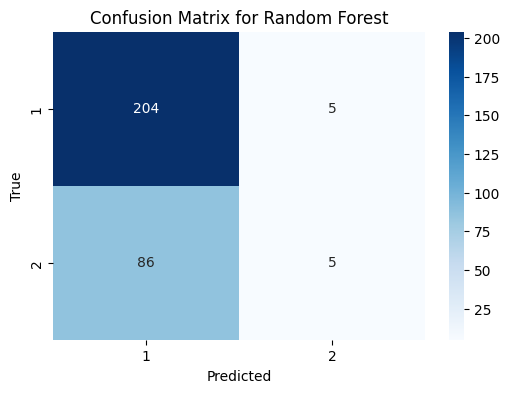

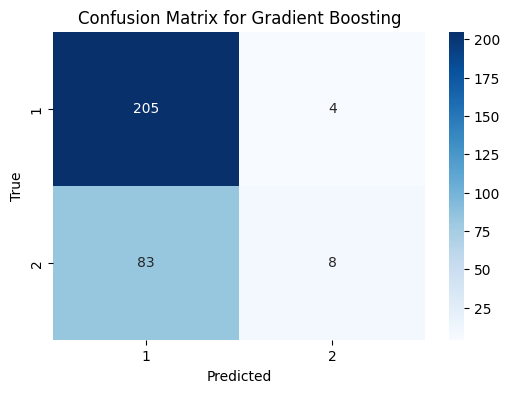

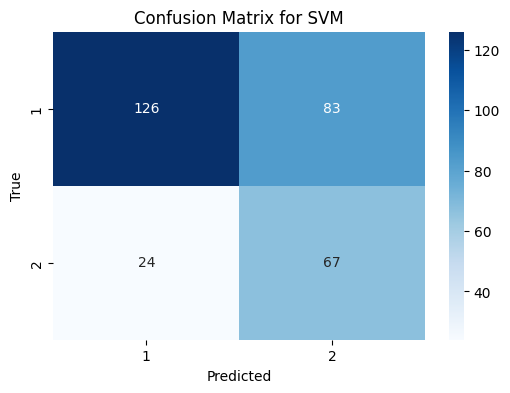

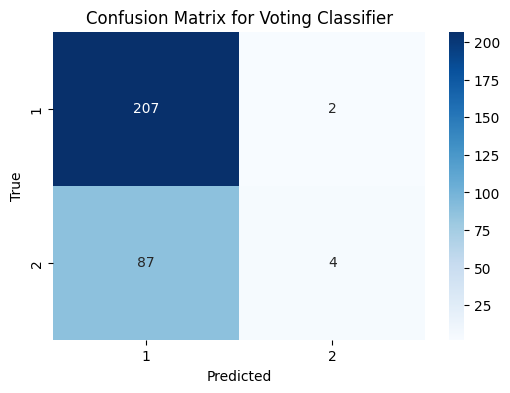

In [ ]:
import seaborn as sns

# Train the models with the resampled data
rf_best.fit(X_train, y_train)
gb_best.fit(X_train, y_train)
svm_best.fit(X_train, y_train)

# Get confusion matrices for each model
models = {
    'Random Forest': rf_best,
    'Gradient Boosting': gb_best,
    'SVM': svm_best,
    'Voting Classifier': voting_clf
}

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2], yticklabels=[1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

for model_name, model in models.items():
    y_pred = model.predict(X_test)  # Make sure model is trained
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)

**Applying Fairness metrics and training the models**

In [ ]:
from fairlearn.metrics import MetricFrame, equalized_odds_difference, demographic_parity_difference
from sklearn.metrics import accuracy_score
import pandas as pd

# Step 1: Load dataset with correct column names
url = "/content/german.data-numeric"  # Adjust the path if necessary
column_names = [
    'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_account', 'employment', 'installment_rate', 'personal_status_sex',
    'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
    'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker',
    'class'
]

# Load the dataset
df = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)

# Ensure that the 'class' column is the label and is separated from features
X = df.drop(columns=['class'])
y = df['class']

# Split into train and test sets (e.g., 80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 2: Train the model (e.g., logistic regression)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# ✅ Step 3: Predict on X_test
y_pred = model.predict(X_test)

# Convert y_test and y_pred to binary {0, 1} labels if necessary
y_test_binary = (y_test == 1).astype(int)  # Convert class 1 to 1 and others to 0
y_pred_binary = (y_pred == 1).astype(int)  # Convert predicted class 1 to 1 and others to 0

# Assuming 'personal_status_sex' is the protected attribute
protected_attribute = X_test['personal_status_sex']

# Create a MetricFrame to calculate fairness metrics
metric_frame = MetricFrame(
    metrics=accuracy_score,
    y_true=y_test_binary,
    y_pred=y_pred_binary,
    sensitive_features=protected_attribute
)

# Compute fairness metrics
equalized_odds = equalized_odds_difference(y_true=y_test_binary, y_pred=y_pred_binary, sensitive_features=protected_attribute)
demographic_parity = demographic_parity_difference(y_true=y_test_binary, y_pred=y_pred_binary, sensitive_features=protected_attribute)

# Print fairness metrics
print("Equalized Odds Difference:", equalized_odds)
print("Demographic Parity Difference:", demographic_parity)
print("Accuracy Metric Frame:\n", metric_frame.overall)

<ipython-input-54-60990ca020fa>:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, header=None, delim_whitespace=True, names=column_names)


Equalized Odds Difference: 0.12056737588652489
Demographic Parity Difference: 0.03125
Accuracy Metric Frame:
 0.72


**Plotting performance before and after Fairness Evaluation**

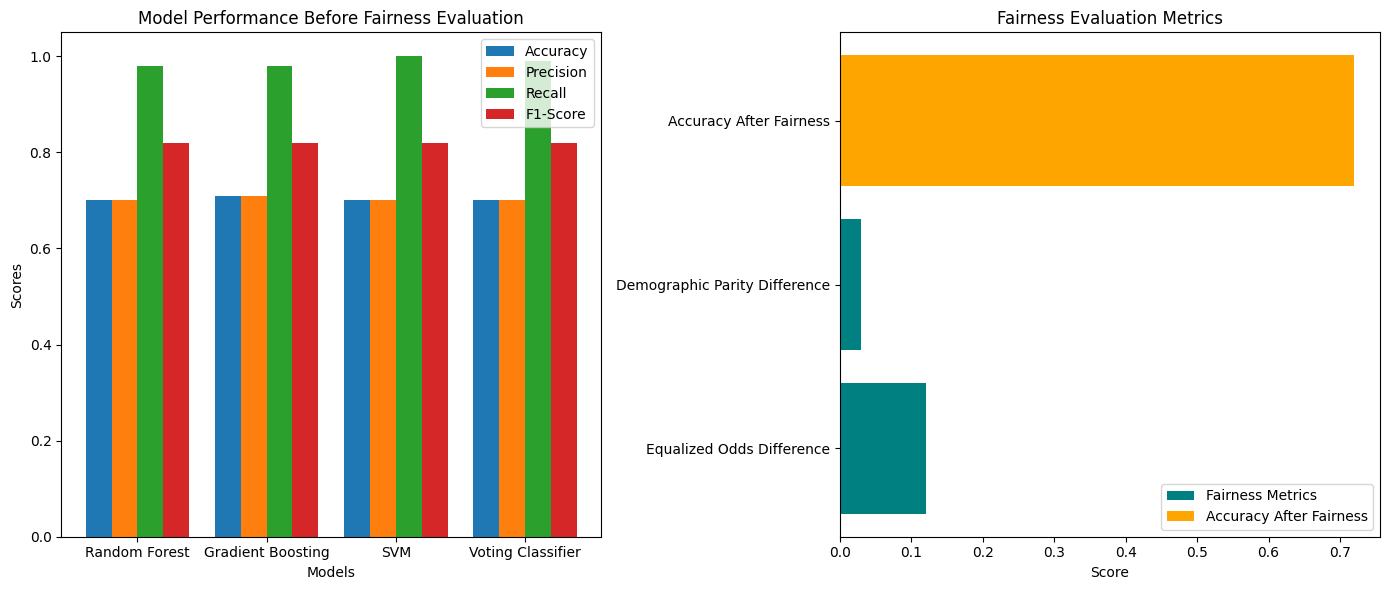

In [ ]:
# Model performance before fairness evaluation
models = ['Random Forest', 'Gradient Boosting', 'SVM', 'Voting Classifier']
accuracy_before = [0.70, 0.71, 0.70, 0.70]
precision_before = [0.70, 0.71, 0.70, 0.70]
recall_before = [0.98, 0.98, 1.00, 0.99]
f1_score_before = [0.82, 0.82, 0.82, 0.82]

# Fairness metrics
equalized_odds_difference = 0.12
demographic_parity_difference = 0.03
accuracy_after_fairness = 0.72

# Plotting performance before and after fairness evaluation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Performance before fairness evaluation
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

ax[0].bar(x - width*1.5, accuracy_before, width, label='Accuracy')
ax[0].bar(x - width*0.5, precision_before, width, label='Precision')
ax[0].bar(x + width*0.5, recall_before, width, label='Recall')
ax[0].bar(x + width*1.5, f1_score_before, width, label='F1-Score')

ax[0].set_xlabel('Models')
ax[0].set_ylabel('Scores')
ax[0].set_title('Model Performance Before Fairness Evaluation')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].legend()

# Fairness evaluation
ax[1].barh([0, 1], [equalized_odds_difference, demographic_parity_difference], color='teal', label='Fairness Metrics')
ax[1].barh([2], [accuracy_after_fairness], color='orange', label='Accuracy After Fairness')

ax[1].set_yticks([0, 1, 2])
ax[1].set_yticklabels(['Equalized Odds Difference', 'Demographic Parity Difference', 'Accuracy After Fairness'])
ax[1].set_xlabel('Score')
ax[1].set_title('Fairness Evaluation Metrics')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()